# Fit LDA ensemble

see: https://radimrehurek.com/gensim/auto_examples/tutorials/run_ensemblelda.html

In [1]:
import pickle
import pandas as pd
from gensim.models import LdaModel
from gensim.models import EnsembleLda
from gensim.models.ldamulticore import LdaMulticore
import numpy as np
import statistics
import os
from matplotlib import pyplot as plt 

%matplotlib inline

In [2]:
DATA_PATH = 'data'
MODELS_PATH = 'models'

## Load dictionary and corpus

Load the dictionary, tokenized train-, validate- and test- corpus prepared in the notebook 01_Clean_and_tokenize.

In [3]:
# Load the datasets for Scholarly Document Processing (SDP)
with open(os.path.join(DATA_PATH, 'dictionary_sdp.pickle'), 'rb') as handle:
    dictionary_sdp = pickle.load(handle)

with open(os.path.join(DATA_PATH, 'corpus_train_sdp.pickle'), 'rb') as handle:
    corpus_train_sdp = pickle.load(handle)

with open(os.path.join(DATA_PATH, 'corpus_validate_sdp.pickle'), 'rb') as handle:
    corpus_validate_sdp = pickle.load(handle)

## Fit ensemble LDA
* Training
* Optimizing the $\epsilon$ parameter
  * Compute perplexity by value of $\epsilon$
  * Plot perplexity curves
  * Find best value of $\epsilon$
* Output SDP topics
* Save the model

### Training

In [11]:
# parameters passed to the fit_ensemble_lda function
topic_model_class = LdaModel
ensemble_workers = 16
num_models = ensemble_workers
distance_workers = 16
num_topics = 50
passes = 16
#iterations = 100
chunksize = 2000

In [12]:
def fit_ensemble_lda(dictionary, corpus):
    """A function to train an ensemble LDA"""
    ensemble = EnsembleLda(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        passes=passes,
        num_models=num_models,
        topic_model_class=topic_model_class,
        ensemble_workers=ensemble_workers,
        distance_workers=distance_workers,
        chunksize=chunksize
    )
    return(ensemble)

### Optimize the epsilon parameter
Parameters for optimizing the $\epsilon$ clustering parameter

In [13]:
max_runs = 5  # the number of times the LDA ensemble will be trained
steps = 25 # the number of steps covering the epsilon range

In [14]:
def get_shape_range(ensemble, steps):
    """Get the range of epsilon values for this ensemble"""
    shape = ensemble.asymmetric_distance_matrix.shape
    without_diagonal = ensemble.asymmetric_distance_matrix[~np.eye(shape[0], dtype=bool)].reshape(shape[0], -1)
    return(np.linspace(without_diagonal.min(), without_diagonal.max(), num=steps))

In [15]:
def compute_perplexity_for_ensemble(dictionary, corpus_train, corpus_validate, max_runs, steps):
    """
    Trains LDA ensemble 'max_run' times, each time with with 'steps' different values of epsilon, return perplexity values.
    @return: a list of dataframes, one dataframe for each run. Each row in the dataframe has 'k' num stable topics, 'eps' clustering parameter epsilon, 'val' perplexity value.
    """
    perplexity = []
    for run in range(max_runs):
        print(f"Run {run + 1} / {max_runs}")
        eps = []
        num_topics_eps = []
        px = []
        ensemble = fit_ensemble_lda(dictionary, corpus_train)
        shape_range = get_shape_range(ensemble, steps)
        for val in shape_range:
            ensemble.recluster(eps=val)
            len_topics = len(ensemble.get_topics())
            num_topics_eps.append(len_topics)
            eps.append(val)
            if len_topics > 1:
                # compute the perplexity for this value of epsilon
                log_perplexity = ensemble.log_perplexity(corpus_validate)
                perplexity_eps = np.exp(-log_perplexity)
                px.append(perplexity_eps)
#                print(f"eps: {val} stable number of topics: {len_topics}, perplexity: {perplexity_eps}")
            else:
                # there's 1 or no stable topics, perplexity is infinite
                px.append(np.inf)
        perplexity.append(pd.DataFrame.from_dict({'k': num_topics_eps, 'eps': eps, 'val': px}))
    return(perplexity)

### Compute perplexity by value of $\epsilon$ clustering parameter for the SDP data set

In [16]:
%%time

perplexity_sdp = compute_perplexity_for_ensemble(dictionary_sdp, corpus_train_sdp, corpus_validate_sdp, max_runs, steps)

Run 1 / 5
Run 2 / 5
Run 3 / 5
Run 4 / 5
Run 5 / 5
CPU times: user 43.1 s, sys: 3.08 s, total: 46.2 s
Wall time: 56min 28s


### Plot the perplexity curves

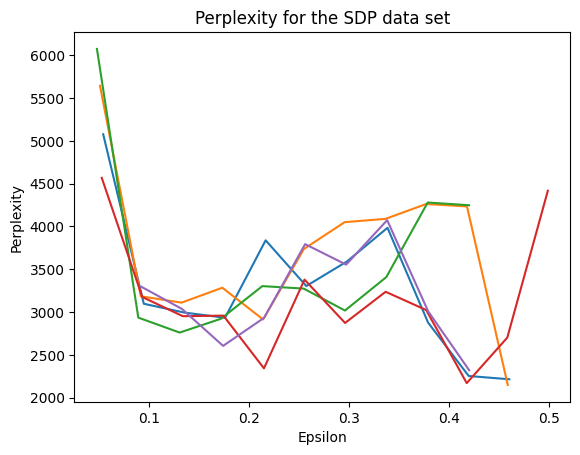

In [17]:
for run in range(max_runs):
    plt.plot(perplexity_sdp[run].eps, perplexity_sdp[run].val)
plt.title("Perplexity for the SDP data set")
plt.xlabel("Epsilon")
plt.ylabel("Perplexity")
plt.show()

### Find the best $\epsilon$ value: mode of list of best values for each run

In [18]:
def find_best_eps(max_runs, perplexity):
    best_eps_runs = []
    for run in range(max_runs):
        best_eps_runs.append(perplexity[run].sort_values('val', ascending=True).iloc[0]['eps'])
    best_eps = statistics.mode(best_eps_runs)
    return(best_eps)

In [19]:
best_eps_sdp = find_best_eps(max_runs, perplexity_sdp)
print(f"Best epsilon value for the Scholarly Document Processing dataset after {max_runs} runs is: {best_eps_sdp}")

Best epsilon value for the Scholarly Document Processing dataset after 5 runs is: 0.4606587026064538


## Scholarly Document Processing topics
Refit the model, with best $\epsilon$.

In [20]:
ensemble_sdp = fit_ensemble_lda(dictionary_sdp, corpus_train_sdp)
ensemble_sdp.recluster(eps=best_eps_sdp, min_samples=2, min_cores=2)
print(f"Found {len(ensemble_sdp.print_topics())} stable topics for the Scholarly Document Processing dataset")
ensemble_sdp.print_topics(num_words=5)

Found 2 stable topics for the Scholarly Document Processing dataset


[(0,
  '0.038*"text" + 0.035*"author" + 0.028*"paper" + 0.027*"article" + 0.023*"http"'),
 (1,
  '0.024*"publishing" + 0.018*"journal" + 0.015*"library" + 0.014*"research" + 0.011*"academic"')]

In [21]:
ensemble_sdp = fit_ensemble_lda(dictionary_sdp, corpus_train_sdp)
ensemble_sdp.recluster(eps=0.1, min_samples=2, min_cores=2)
print(f"Found {len(ensemble_sdp.print_topics())} stable topics for the Scholarly Document Processing dataset")
ensemble_sdp.print_topics(num_words=5)

Found 8 stable topics for the Scholarly Document Processing dataset


[(0,
  '0.102*"review" + 0.086*"peer" + 0.039*"reviewer" + 0.018*"editor" + 0.018*"manuscript"'),
 (1,
  '0.092*"journal" + 0.022*"article" + 0.022*"publishing" + 0.015*"publisher" + 0.012*"publication"'),
 (2,
  '0.089*"journal" + 0.084*"predatory" + 0.028*"publishing" + 0.015*"publisher" + 0.013*"researcher"'),
 (3,
  '0.069*"open" + 0.058*"access" + 0.021*"research" + 0.020*"publishing" + 0.019*"journal"'),
 (4,
  '0.035*"text" + 0.034*"author" + 0.030*"article" + 0.026*"paper" + 0.023*"share"'),
 (5,
  '0.089*"library" + 0.025*"collection" + 0.018*"resource" + 0.015*"university" + 0.013*"service"'),
 (6, '0.072*"le" + 0.065*"de" + 0.018*"pour" + 0.014*"sur" + 0.014*"dans"'),
 (7,
  '0.103*"data" + 0.038*"research" + 0.025*"policy" + 0.011*"sharing" + 0.009*"management"')]